**Fake News Detection Model for Social Networks using Graph Technology**

In this notebook, a GNN model will be developed and compared with some other methods (e.g., classic machine learning methods, DistilBERT).

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/FakeNewsNet.csv')
data = data.dropna()
data.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Analysis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22866 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          22866 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   tweet_num      22866 non-null  int64 
 4   real           22866 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.0+ MB


In [ ]:
data['real'].value_counts()

1    17371
0     5495
Name: real, dtype: int64

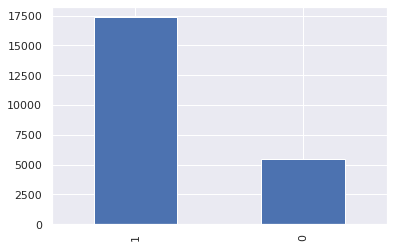

In [ ]:
data['real'].value_counts().plot.bar();

Сlasses are not balanced.

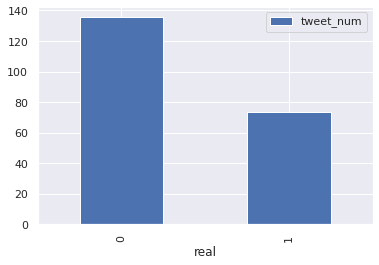

In [ ]:
data.groupby('real').mean().plot.bar();

Fake news is on average more popular.

Most popular news sources:

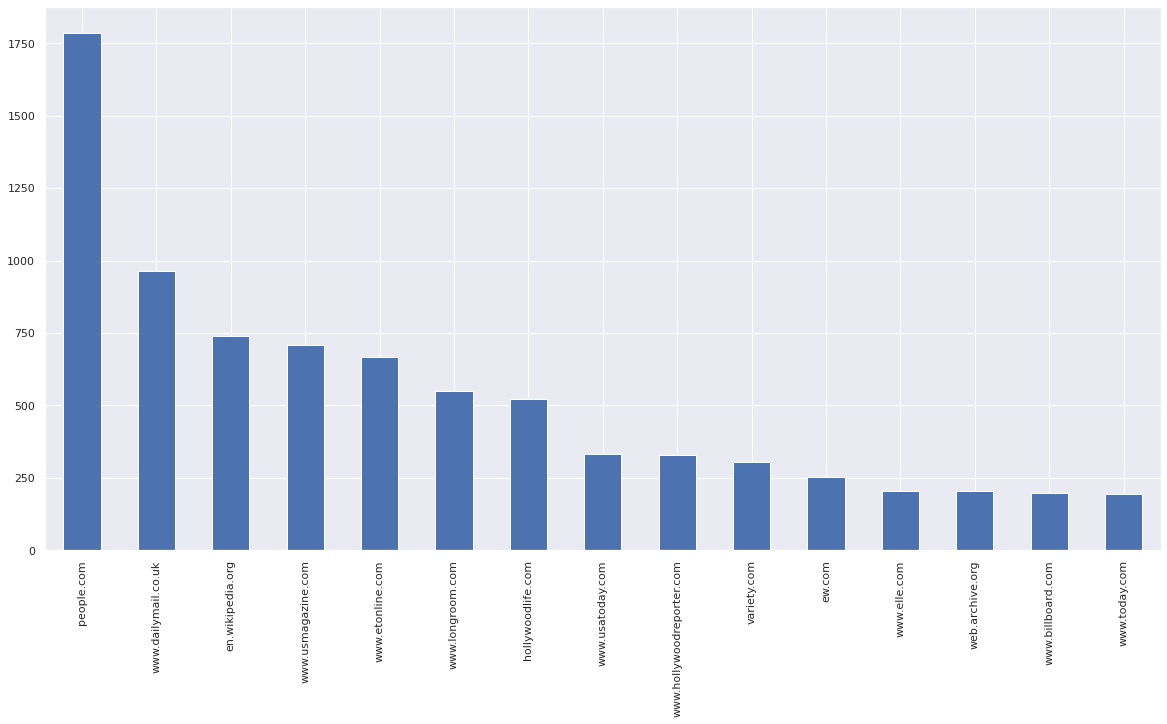

In [ ]:
data['source_domain'].value_counts()[:15].plot.bar(figsize=(20, 10));

The most popular sources of real news:

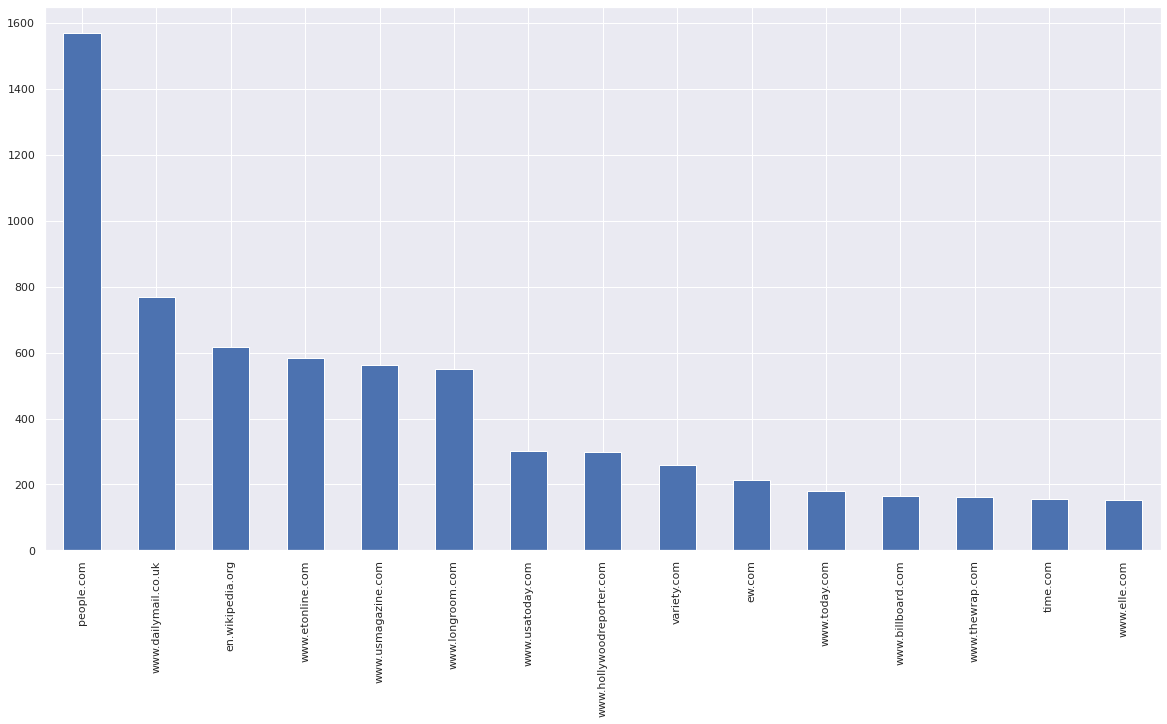

In [ ]:
data.loc[data['real'] == 1]['source_domain'].value_counts()[:15].plot.bar(figsize=(20, 10));

The most popular sources of fake news:

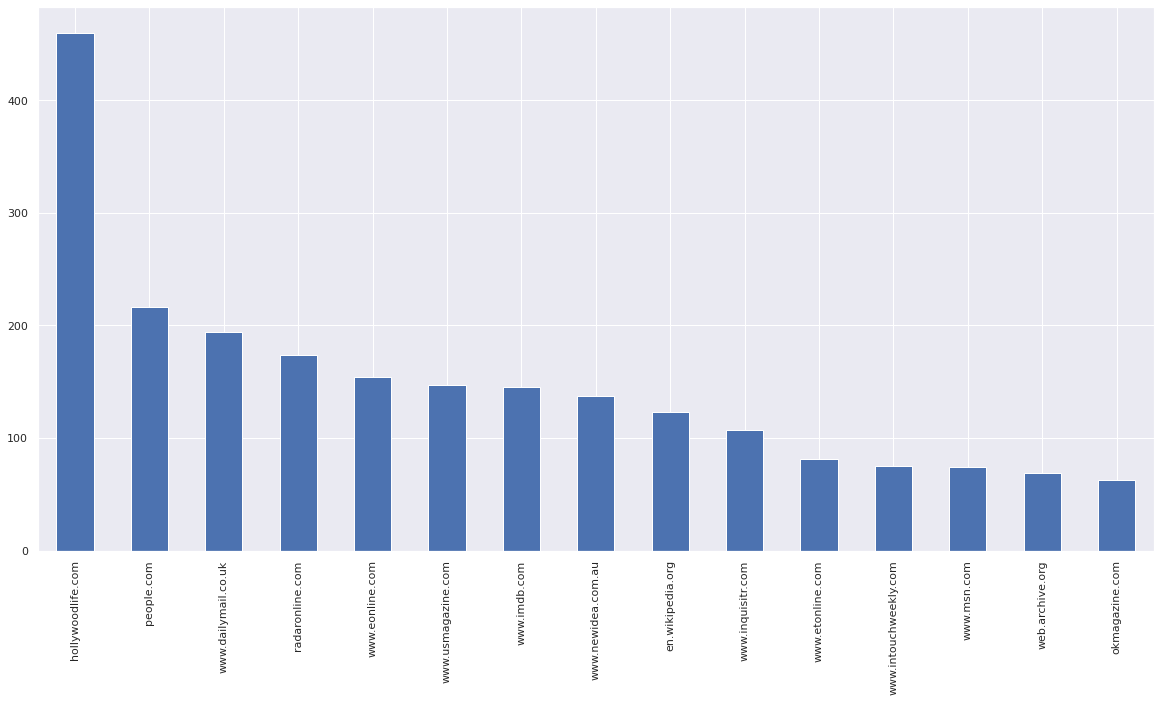

In [ ]:
data.loc[data['real'] == 0]['source_domain'].value_counts()[:15].plot.bar(figsize=(20, 10));

**Wordclouds:**

In [ ]:
from wordcloud import WordCloud

def make_wordcloud(text):
    wordcloud = WordCloud(background_color='white', width=2000, height=2000).generate(text)
    plt.figure(figsize = (15,15))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

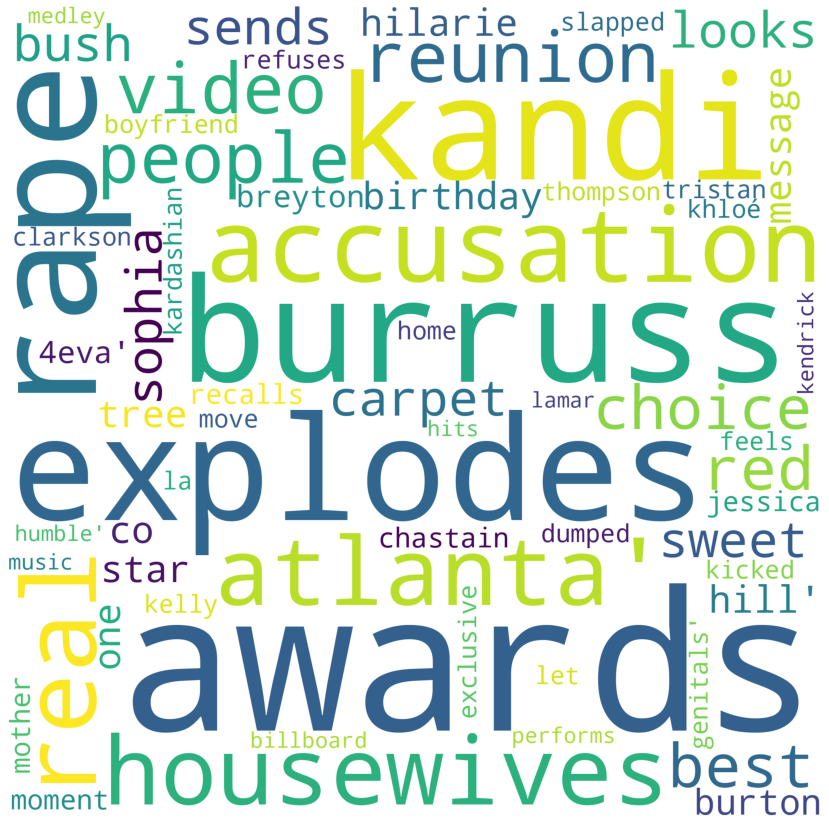

In [ ]:
txt = str(data['title'].values).lower()
make_wordcloud(txt)

Real news:

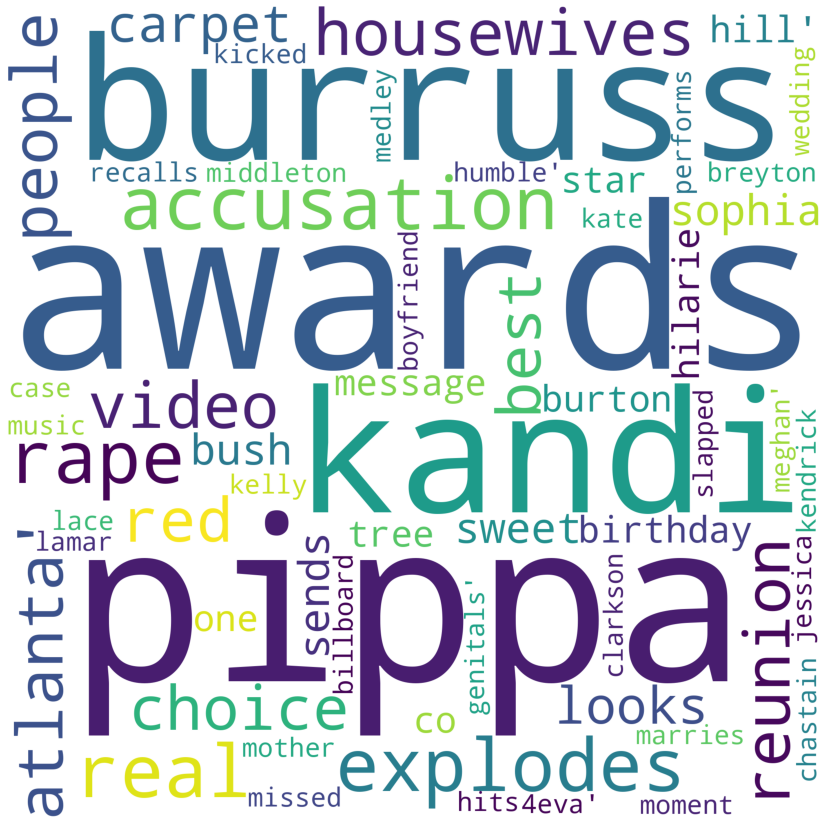

In [ ]:
txt = str(data.loc[data['real'] == 1]['title'].values).lower()
make_wordcloud(txt)

Fake news:

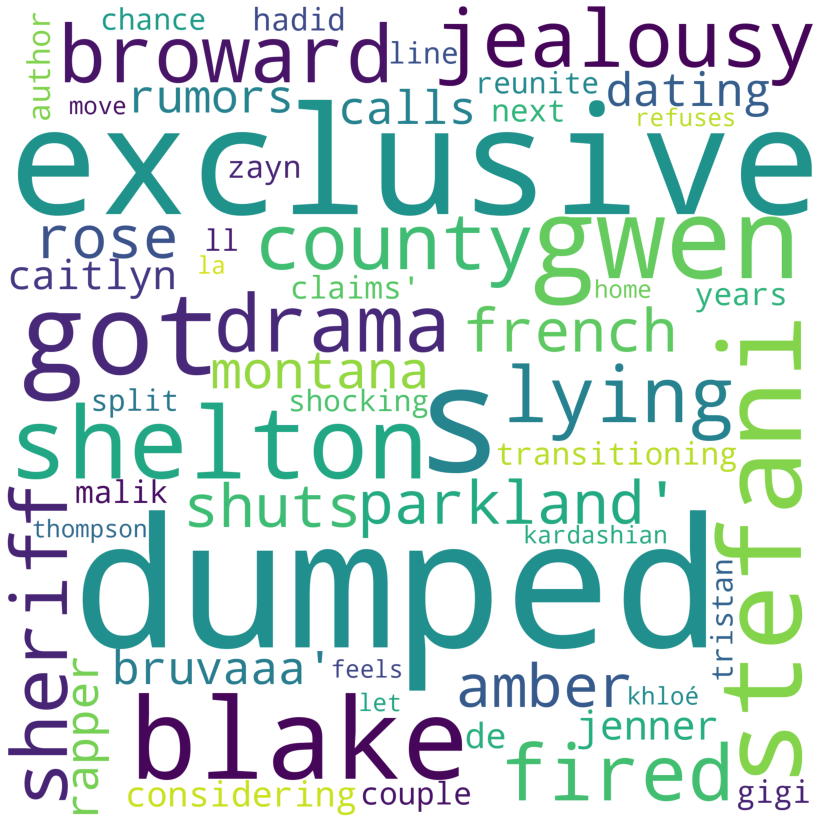

In [ ]:
txt = str(data.loc[data['real'] == 0]['title'].values).lower()
make_wordcloud(txt)

# Classic machine learning methods

Transforming the data:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = data[['title']]
y = data[['real']]

le = preprocessing.LabelEncoder()
#X['source_domain'] = le.fit_transform(X['source_domain']);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

Creating pipelines:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

clf_NB = make_pipeline(CountVectorizer(), 
                       TfidfTransformer(), 
                       BernoulliNB())

clf_SVM = make_pipeline(CountVectorizer(), 
                       TfidfTransformer(), 
                       LinearSVC())

clf_log = make_pipeline(CountVectorizer(), 
                       TfidfTransformer(), 
                       LogisticRegression())


Naive Bayes:

In [ ]:
from sklearn.metrics import classification_report

clf_NB.fit(X_train.values.ravel(), y_train)
predicted1 = clf_NB.predict(X_test.values.ravel())

target_names = ['fake', 'real']
print(classification_report(y_test, predicted1, target_names=target_names))

              precision    recall  f1-score   support

        fake       0.72      0.54      0.61      1103
        real       0.86      0.93      0.90      3471

    accuracy                           0.84      4574
   macro avg       0.79      0.73      0.76      4574
weighted avg       0.83      0.84      0.83      4574



SVM:

In [ ]:
clf_SVM.fit(X_train.values.ravel(), y_train)
predicted2 = clf_SVM.predict(X_test.values.ravel())

target_names = ['fake', 'real']
print(classification_report(y_test, predicted2, target_names=target_names))

              precision    recall  f1-score   support

        fake       0.70      0.54      0.61      1103
        real       0.86      0.93      0.89      3471

    accuracy                           0.83      4574
   macro avg       0.78      0.73      0.75      4574
weighted avg       0.83      0.83      0.83      4574



Logistic Regression:

In [ ]:
clf_log.fit(X_train.values.ravel(), y_train)
predicted3 = clf_log.predict(X_test.values.ravel())

target_names = ['fake', 'real']
print(classification_report(y_test, predicted3, target_names=target_names))

              precision    recall  f1-score   support

        fake       0.81      0.43      0.56      1103
        real       0.84      0.97      0.90      3471

    accuracy                           0.84      4574
   macro avg       0.83      0.70      0.73      4574
weighted avg       0.84      0.84      0.82      4574



# DistilBERT

In [ ]:
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 85.4 MB/s eta 0:00:00


In [ ]:
import transformers as ppb

df = data[:5000]

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenized = df['title'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(5000, 50)

In [ ]:
input_ids = torch.tensor(np.array(padded)).to(device)

with torch.no_grad():
    last_hidden_states = model(input_ids)

In [ ]:
features = last_hidden_states[0][:,0,:].cpu().numpy()

In [ ]:
labels = df['real']
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

In [ ]:
lr_clf.score(test_features, test_labels)

0.8416

In [ ]:
predicted4 = lr_clf.predict(test_features)

target_names = ['fake', 'real']
print(classification_report(test_labels, predicted4, target_names=target_names))

              precision    recall  f1-score   support

        fake       0.73      0.41      0.53       268
        real       0.86      0.96      0.90       982

    accuracy                           0.84      1250
   macro avg       0.79      0.69      0.72      1250
weighted avg       0.83      0.84      0.82      1250



# Graph Neural Networks

In [ ]:
vers = torch.__version__
print("Torch vers: ", vers)

Torch vers:  1.13.1+cu116


In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git
!pip install networkx --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 68.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch_geometric
from torch_geometric.datasets import UPFD
train_data = UPFD(root=".", name="gossipcop", feature="content", split="train")
val_data = UPFD(root=".", name="gossipcop", feature="content", split="train")
test_data = UPFD(root=".", name="gossipcop", feature="content", split="test")

In [ ]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

In [ ]:
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch_geometric.nn import GATv2Conv
from torch.nn import Linear

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        # Graph Convolutions
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        # Pooling
        h = gmp(h, batch)

        # Readout
        h = self.lin0(h).relu()

        # According to UPFD paper: Include raw word2vec embeddings of news 
        # This is done per graph in the batch
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]
        news = self.lin_news(news).relu()
        
        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

GNN(train_data.num_features, 128, 1)

GNN(
  (conv1): GATConv(310, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (lin_news): Linear(in_features=310, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

In [ ]:
def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    # Calculate Metrics
    accuracy, f1 = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), accuracy , f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    acc = accuracy_score(preds.cpu().numpy(), gts.cpu().numpy())
    f1 = f1_score(preds.cpu().numpy(), gts.cpu().numpy())
    return acc, f1

In [ ]:
for epoch in range(40):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | '
          f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')

Epoch: 00 |  TrainLoss: 0.73 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 01 |  TrainLoss: 0.70 | TestLoss: 0.71 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 02 |  TrainLoss: 0.70 | TestLoss: 0.69 | TestAcc: 0.51 | TestF1: 0.03
Epoch: 03 |  TrainLoss: 0.70 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 04 |  TrainLoss: 0.70 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 05 |  TrainLoss: 0.68 | TestLoss: 0.70 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 06 |  TrainLoss: 0.69 | TestLoss: 0.68 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 07 |  TrainLoss: 0.69 | TestLoss: 0.68 | TestAcc: 0.52 | TestF1: 0.09
Epoch: 08 |  TrainLoss: 0.68 | TestLoss: 0.68 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 09 |  TrainLoss: 0.68 | TestLoss: 0.67 | TestAcc: 0.54 | TestF1: 0.15
Epoch: 10 |  TrainLoss: 0.67 | TestLoss: 0.70 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 11 |  TrainLoss: 0.70 | TestLoss: 0.72 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 12 |  TrainLoss: 0.69 | TestLoss: 0.68 | TestAcc: 0.50 | TestF1: 0.00